In [23]:
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
from operator import itemgetter
import math
from sklearn.model_selection import train_test_split

    
def I(df, I_type): #misscl
    if I_type == 'misscl':
        if df.empty:
            return 0
        p = (df.label == 1).sum()/df.shape[0]
        return min(p,1-p)
    if I_type == 'entropy':
        if df.empty:
            return 0
        p = (df.label == 1).sum()/df.shape[0]
        if p in [0,1]:
            return 0
        else:
            return -p*math.log2(p)-(1-p)*math.log2(1-p)
    if I_type == 'gini':
        if df.empty:
            return 0
        p = (df.label == 1).sum()/df.shape[0]
        return 2*p*(1-p)
    
#node = [name, df, rule]

def l_less_r(df1, df2):
    p1 = (df1.label == 1).sum()/df1.shape[0]
    p2 = (df2.label == 1).sum()/df2.shape[0]
    if p1<p2:
        return 1
    else:
        return 0

def separate_train(node, I_type):
    name = node[0]
    x = node[1]
    IG_arr = []
    for col in list(x.drop('label', axis=1).columns.values):
        for a in list(set(x[col])):
            IG = x.shape[0]/X_train_nrow*I(x, I_type)-x[x[col]<a].shape[0]/X_train_nrow*I(x[x[col]<a], I_type)-x[x[col]>=a].shape[0]/X_train_nrow*I(x[x[col]>=a], I_type)
            IG_arr.append([col, a, IG])
    col, a = max(IG_arr, key=itemgetter(2))[0], max(IG_arr, key=itemgetter(2))[1]
    node[2]=[col, a]
    node_l = [name+[0], x[x[col]<a], None]
    node_r = [name+[1], x[x[col]>=a], None]
    return node, node_l, node_r, [name, col, a, l_less_r(node_l[1], node_r[1])]

    
def make_tree(tree, I_type):
    leaf = []
    branch = []
    rules = []
    while len(tree)>0:
        node = tree[0]
        df = node[1]
        if (df.label == 1).sum() == df.shape[0]:
            leaf.append(node)
            tree.pop(0)
        elif (df.label == 0).sum() == df.shape[0]:
            leaf.append(node)
            tree.pop(0)
        elif len(node[0])==K:
            leaf.append(node)
            tree.pop(0)
        else:
            node, node_l, node_r, rule = separate_train(node, I_type)
            #print(rule)
            rules.append(rule)
            branch.append(node)
            tree.pop(0)
            tree.append(node_l)
            tree.append(node_r)
    return tree, leaf, branch, rules
        

In [43]:
import numpy as np

#node = [name, df]
def separate_val(node, rules):
    name = node[0]
    x = node[1]
    for r in rules:
        if name == r[0]:
            col = r[1]
            a = r[2]
            if r[3]==1:
                node_l = [name+[0], x[x[col]<a], 0]
                node_r = [name+[1], x[x[col]>=a], 1]
            else:
                node_l = [name+[0], x[x[col]<a], 1]
                node_r = [name+[1], x[x[col]>=a], 0]
            return node_l, node_r
            
    
def make_tree_val(tree, rules, K_2):
    leaf = []
    while len(tree)>0:
        node = tree[0]
        if len(node[0]) >= K_2:
            leaf.append(node)
            tree.pop(0)
        elif node[0] not in list(zip(*rules))[0]:
            leaf.append(node)
            tree.pop(0)
        else:
            node_l, node_r = separate_val(node, rules)
            tree.append(node_l)
            tree.append(node_r)
            tree.pop(0)
    return leaf

def acc(leaf_2):
    true_cnt = 0
    all_cnt = 0
    for n in range(0,len(leaf_2)):
        m = leaf_2[n][1]
        all_cnt += m.shape[0]
        u = m[m.label==leaf_2[n][2]].shape[0]
        true_cnt += u
    return true_cnt/all_cnt



def gr(leaf_2):
    roc_data = []
    for l in leaf_2:
        roc_data.append([l[1].shape[0], l[1].loc[:,"label"].mean()])
    #print(roc_data)
    R=[]
    for xx in sorted(list(set(list(zip(*roc_data))[1]))):
        if np.isnan(xx)==0:
            TN=0
            FN=0
            TP=0
            FP=0
            for s in roc_data:
                if s[1]<xx:
                    TN+=s[0]*(1-s[1])
                    FN+=s[0]*s[1]
                if s[1]>=xx:
                    TP+=s[0]*s[1]
                    FP+=s[0]*(1-s[1])
            #print(xx, TP, FN)
            TPR = TP/(TP+FN)
            FPR = FP/(FP+TN)
            R.append([FPR, TPR])
    R = sorted(R, key=itemgetter(0,1))
    print('roc auc =', np.trapz(list(zip(*R))[1], x = list(zip(*R))[0]))
    plt.plot(list(zip(*R))[0], list(zip(*R))[1])


In [24]:
df = pd.read_csv('/Users/dashabalashova/1_1_5_ML_Bioinf/data/spam.csv')
train, validate = train_test_split(df, test_size=0.2, stratify=df.label)
X_train_nrow = train.shape[0]


K = 10     
tree, leaf, branch, rules = make_tree([[[], train, None]], 'gini')        
print()
for K_2 in range(1,11):
    leaf_2 = make_tree_val([[[], validate, 0.5]], rules, K_2)
    print('depth =', K_2,'acc =', acc(leaf_2))


depth = 1 acc = 0.7774158523344191
depth = 2 acc = 0.8588490770901195
depth = 3 acc = 0.8545059717698155
depth = 4 acc = 0.8675352877307275
depth = 5 acc = 0.9066232356134636
depth = 6 acc = 0.8935939196525515
depth = 7 acc = 0.9033659066232356
depth = 8 acc = 0.9120521172638436
depth = 9 acc = 0.8881650380021715
depth = 10 acc = 0.9131378935939196


gini
roc auc = 0.9502058710269854


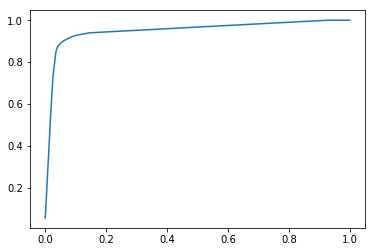

In [46]:
print('gini')
leaf_2 = make_tree_val([[[], validate, 0.5]], rules, 10)
gr(leaf_2)

In [47]:
K = 10     
tree, leaf, branch, rules_misscl = make_tree([[[], train, None]], 'misscl')        

for K_2 in range(1,11):
    leaf_2 = make_tree_val([[[], validate, 0.5]], rules_misscl, K_2)
    print('depth =',K_2,'acc =', acc(leaf_2))

/Users/dashabalashova/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in long_scalars


depth = 1 acc = 0.7774158523344191
depth = 2 acc = 0.8588490770901195
depth = 3 acc = 0.8827361563517915
depth = 4 acc = 0.8968512486427795
depth = 5 acc = 0.8892508143322475
depth = 6 acc = 0.8925081433224755
depth = 7 acc = 0.8957654723127035
depth = 8 acc = 0.8957654723127035
depth = 9 acc = 0.6634093376764386
depth = 10 acc = 0.8317046688382194


misscl
roc auc = 0.8949341903887359


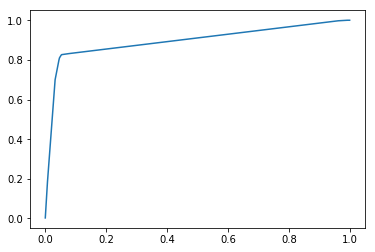

In [49]:
print('misscl')
leaf_2 = make_tree_val([[[], validate, 0.5]], rules_misscl, 4)
gr(leaf_2)

In [50]:
K = 10     
tree, leaf, branch, rules_entropy = make_tree([[[], train, None]], 'entropy')        

for K_2 in range(1,11):
    leaf_2 = make_tree_val([[[], validate, 0.5]], rules_entropy, K_2)
    print('depth =',K_2,'acc =', acc(leaf_2))

/Users/dashabalashova/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in long_scalars


depth = 1 acc = 0.7774158523344191
depth = 2 acc = 0.8078175895765473
depth = 3 acc = 0.8762214983713354
depth = 4 acc = 0.6167209554831705
depth = 5 acc = 0.8501628664495114
depth = 6 acc = 0.6807817589576547
depth = 7 acc = 0.8338762214983714
depth = 8 acc = 0.8023887079261672
depth = 9 acc = 0.8653637350705755
depth = 10 acc = 0.8718783930510315


entropy
roc auc = 0.9788229311689722


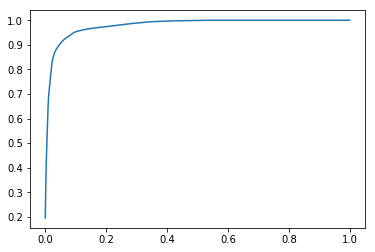

In [52]:
print('entropy')
leaf_2 = make_tree_val([[[], validate, 0.5]], rules_entropy, 10)
gr(leaf_2)